In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

TEST LOOKBACK VALUES FOR SINGLE LSTM USING ADJUSTED CLOSE AS INPUT
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_0

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close  Volume
0     0  1995-01-03  30.574097  324300
1     1  1995-01-04  30.720218  351800
2     2  1995-01-05  30.720218   89800
3     3  1995-01-06  30.751472  448400
4     4  1995-01-09  30.782794   36800
---
      Item        Date   Adj_Close     Volume
5147  5147  2015-06-12  201.460969  135382400
5148  5148  2015-06-15  200.597612  124384200
5149  5149  2015-06-16  201.691205   85308200
5150  5150  2015-06-17  202.017360  126708600
5151  5151  2015-06-18  204.118213  165867900


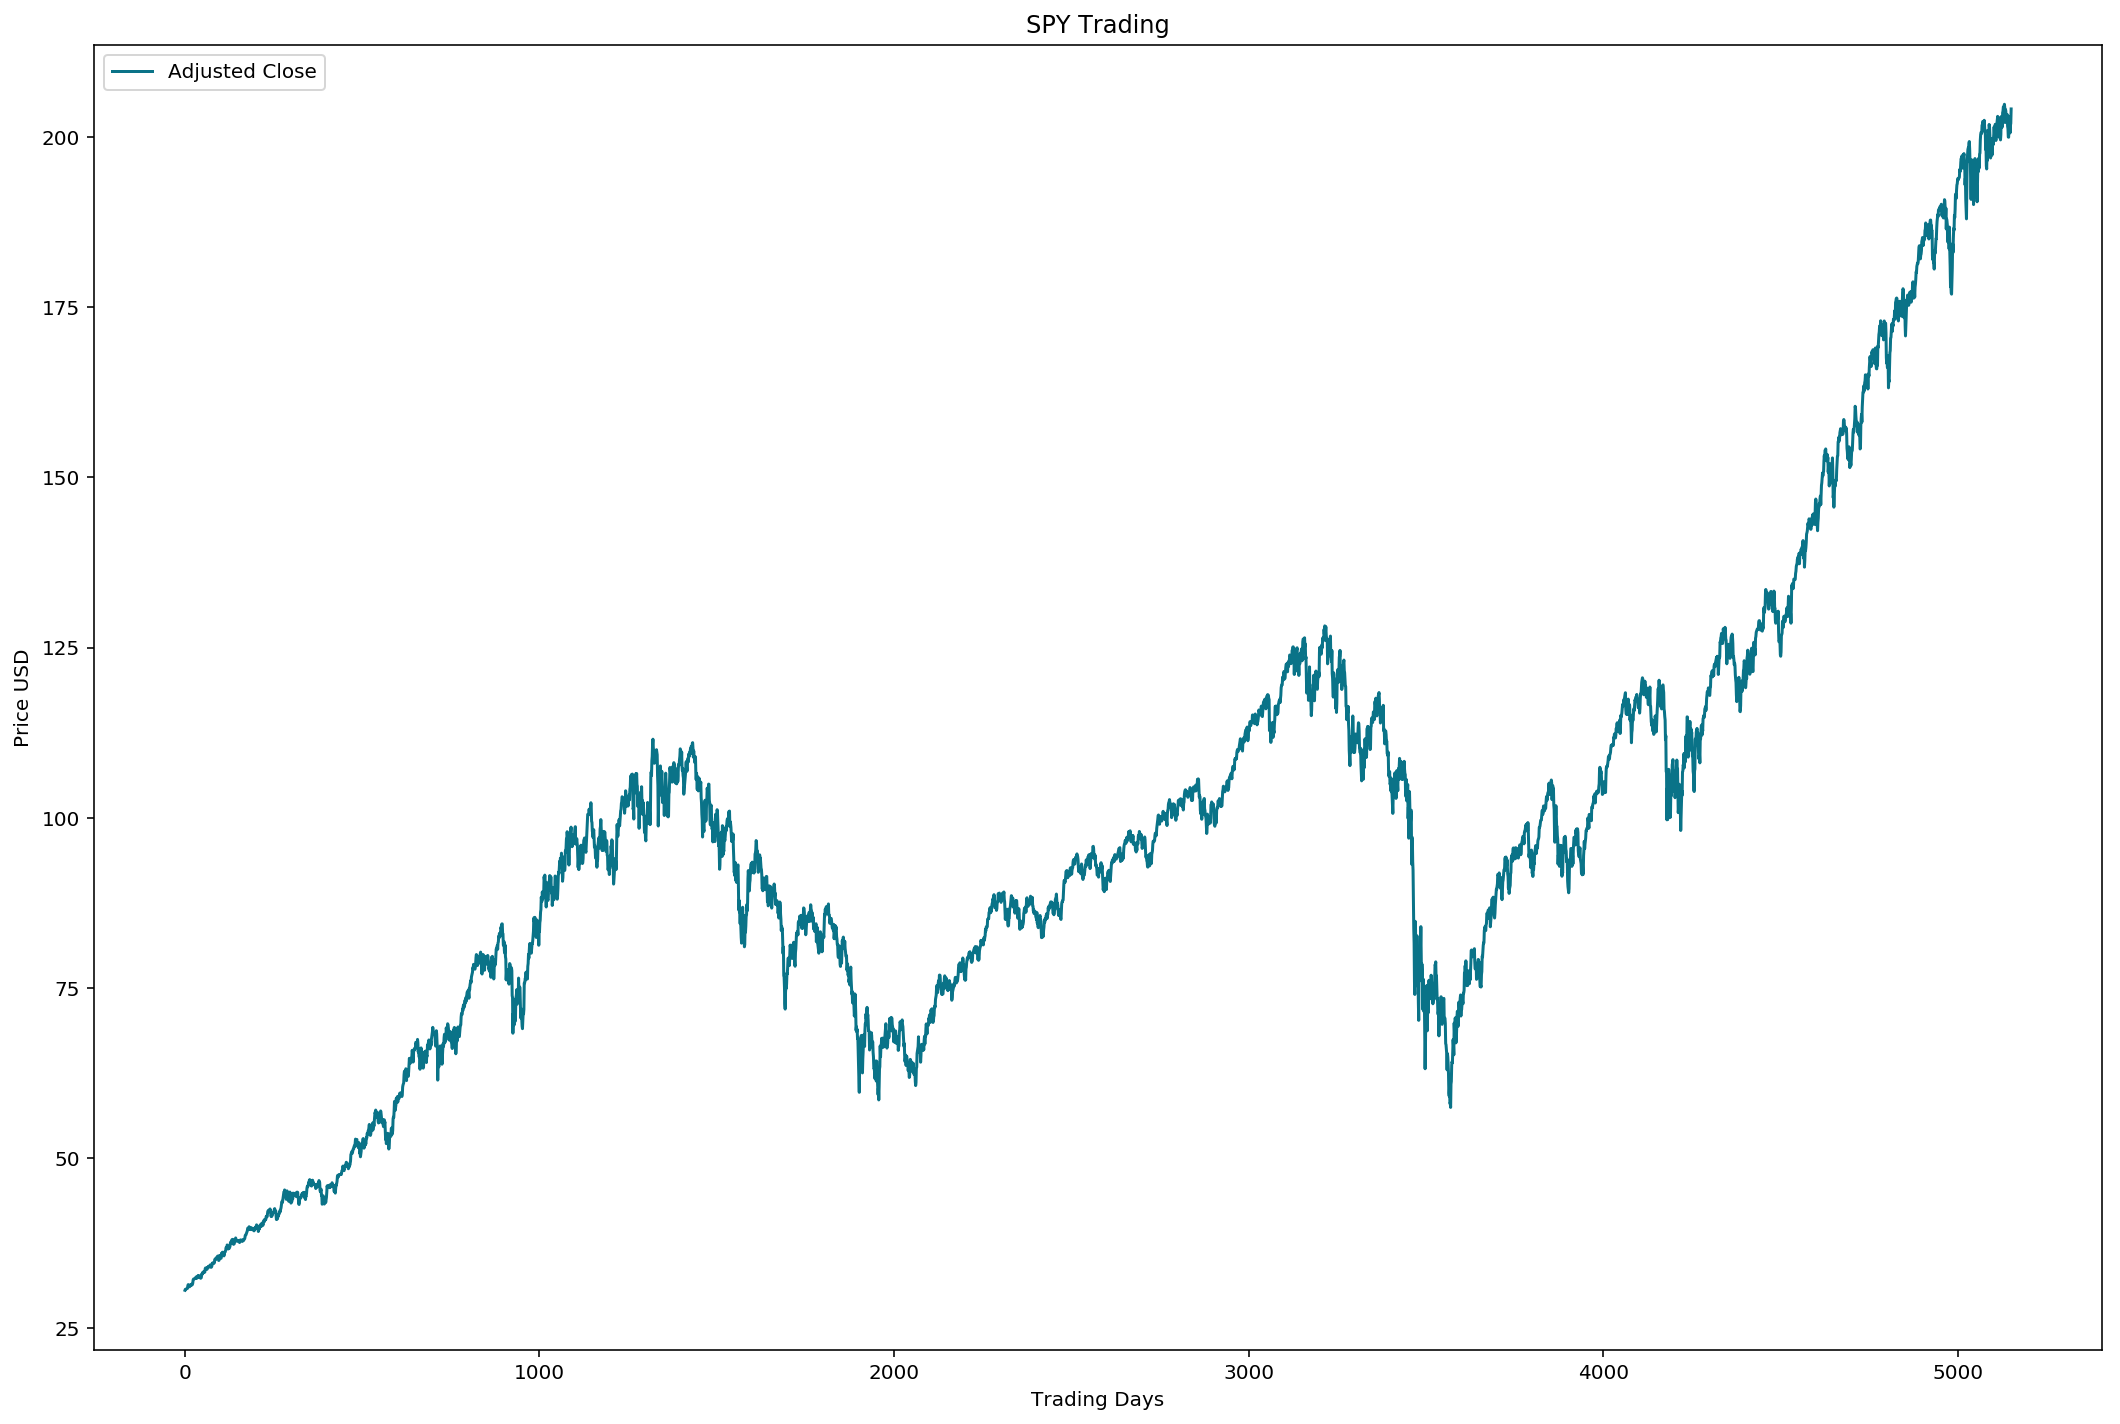

In [4]:
#Plot Basic Data
fig, ax = plt.subplots()
ax.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')

# format the coords message box
def price(x):
    return '$%1.2f' % x
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Add title and legend
ax.set_title(base_ticker + ' Trading')
ax.legend(loc='upper left')

plt.show()

In [5]:
#Create numpy arrays for features and targets
X_day_all = []
close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_day_all.append([(row['Item'])])
    close_all.append([(row['Adj_Close'])])

#pprint(X_day_all)
pprint(close_all)

[[30.574097],
 [30.720218],
 [30.720218],
 [30.751471999999996],
 [30.782794],
 [30.814114],
 [30.83495],
 [30.845436],
 [31.210604999999997],
 [31.398466],
 [31.408884999999998],
 [31.377563000000002],
 [31.200188],
 [31.085387],
 [31.179352],
 [31.221090999999998],
 [31.304570000000002],
 [31.335824],
 [31.461042],
 [31.325407000000002],
 [31.450625],
 [31.440205],
 [31.628],
 [32.076716],
 [32.212351],
 [32.254090999999995],
 [32.254090999999995],
 [32.254090999999995],
 [32.29583],
 [32.306315999999995],
 [32.348056],
 [32.52543],
 [32.483691],
 [32.358473],
 [32.348056],
 [32.588006],
 [32.640232],
 [32.72371],
 [32.462788],
 [32.734127],
 [32.52543],
 [32.567170000000004],
 [32.577589],
 [32.598492],
 [32.348056],
 [32.431534],
 [32.421049],
 [32.901084999999995],
 [32.869765],
 [33.109782],
 [33.04714],
 [33.24542],
 [33.278523],
 [33.278523],
 [33.194592],
 [33.226015000000004],
 [33.247031],
 [33.719126],
 [33.855495],
 [33.855495],
 [33.845022],
 [33.782107],
 [33.645669],
 [

In [6]:
# Reshape into t and t+1
look_back = 40 #1
tt_split = (1.0-.315)
#X_day_train_t, X_day_train_t1, X_day_test_t, X_day_test_t1 = create_dataset(X_day_all, look_back, tt_split, True)
#X_vol_train_t, X_vol_train_t1 = create_dataset(X_vol_train, look_back, True)
X_close_train, y_close_train, X_close_test, y_close_test, close_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)

pprint(X_close_train)
print('--')
pprint(y_close_train)

array([[[ 0.        ],
        [ 0.00083864],
        [ 0.00083864],
        ..., 
        [ 0.01233745],
        [ 0.01083992],
        [ 0.01239724]],

       [[ 0.00083864],
        [ 0.00083864],
        [ 0.00101802],
        ..., 
        [ 0.01083992],
        [ 0.01239724],
        [ 0.01119944]],

       [[ 0.00083864],
        [ 0.00101802],
        [ 0.00119779],
        ..., 
        [ 0.01239724],
        [ 0.01119944],
        [ 0.01143901]],

       ..., 
       [[ 0.18678216],
        [ 0.20632347],
        [ 0.23277868],
        ..., 
        [ 0.23304342],
        [ 0.23623799],
        [ 0.21450514]],

       [[ 0.20632347],
        [ 0.23277868],
        [ 0.23580353],
        ..., 
        [ 0.23623799],
        [ 0.21450514],
        [ 0.23134934]],

       [[ 0.23277868],
        [ 0.23580353],
        [ 0.25169584],
        ..., 
        [ 0.21450514],
        [ 0.23134934],
        [ 0.22505695]]])
--
array([[ 0.01119944],
       [ 0.01143901],
       [ 0.01149

In [7]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Create and fit the LSTM network
batch_size = 1
epochs = 1 # 200
n_nodes = [128]

# Create the LSTM model
model = Sequential()
model.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back, 1)))
model.add(Dense(1))
model.add(Activation('linear'))

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print 'compilation time : ', time.time() - start

compilation time :  0.386422872543


In [8]:
# Train the model
model.fit(X_close_train, 
          y_close_train, 
          nb_epoch=epochs, 
          batch_size=batch_size, 
          verbose=2)

Epoch 1/1
89s - loss: 2.9442e-04


In [9]:
# Generate predictions for training
#testPredict = model.predict(X_close_test, batch_size=batch_size)
testPredict = util.predict_sequences(model, X_close_test)
pprint(testPredict)

[[0.2210186],
 [0.22173592],
 [0.22364931],
 [0.22873785],
 [0.230324],
 [0.22872137],
 [0.22605686],
 [0.22474776],
 [0.22356175],
 [0.22418165],
 [0.2279498],
 [0.23200308],
 [0.23085786],
 [0.22908676],
 [0.22729129],
 [0.22480281],
 [0.21870677],
 [0.21280386],
 [0.20723279],
 [0.20226659],
 [0.19563895],
 [0.19340166],
 [0.19225398],
 [0.19058836],
 [0.1874126],
 [0.18081237],
 [0.17409359],
 [0.17055804],
 [0.16549727],
 [0.16154563],
 [0.15793487],
 [0.15988223],
 [0.16357674],
 [0.17045759],
 [0.17743823],
 [0.18268608],
 [0.18872866],
 [0.19531396],
 [0.19931181],
 [0.19966044],
 [0.20490149],
 [0.20819612],
 [0.2113536],
 [0.2155478],
 [0.21730551],
 [0.2147883],
 [0.21233909],
 [0.211981],
 [0.21500261],
 [0.21940234],
 [0.2226661],
 [0.22272623],
 [0.2227726],
 [0.22630922],
 [0.22996779],
 [0.23128565],
 [0.23266269],
 [0.2349949],
 [0.2376617],
 [0.23565337],
 [0.23466472],
 [0.23333935],
 [0.23320727],
 [0.23493551],
 [0.23594534],
 [0.23633724],
 [0.23851827],
 [0.24067

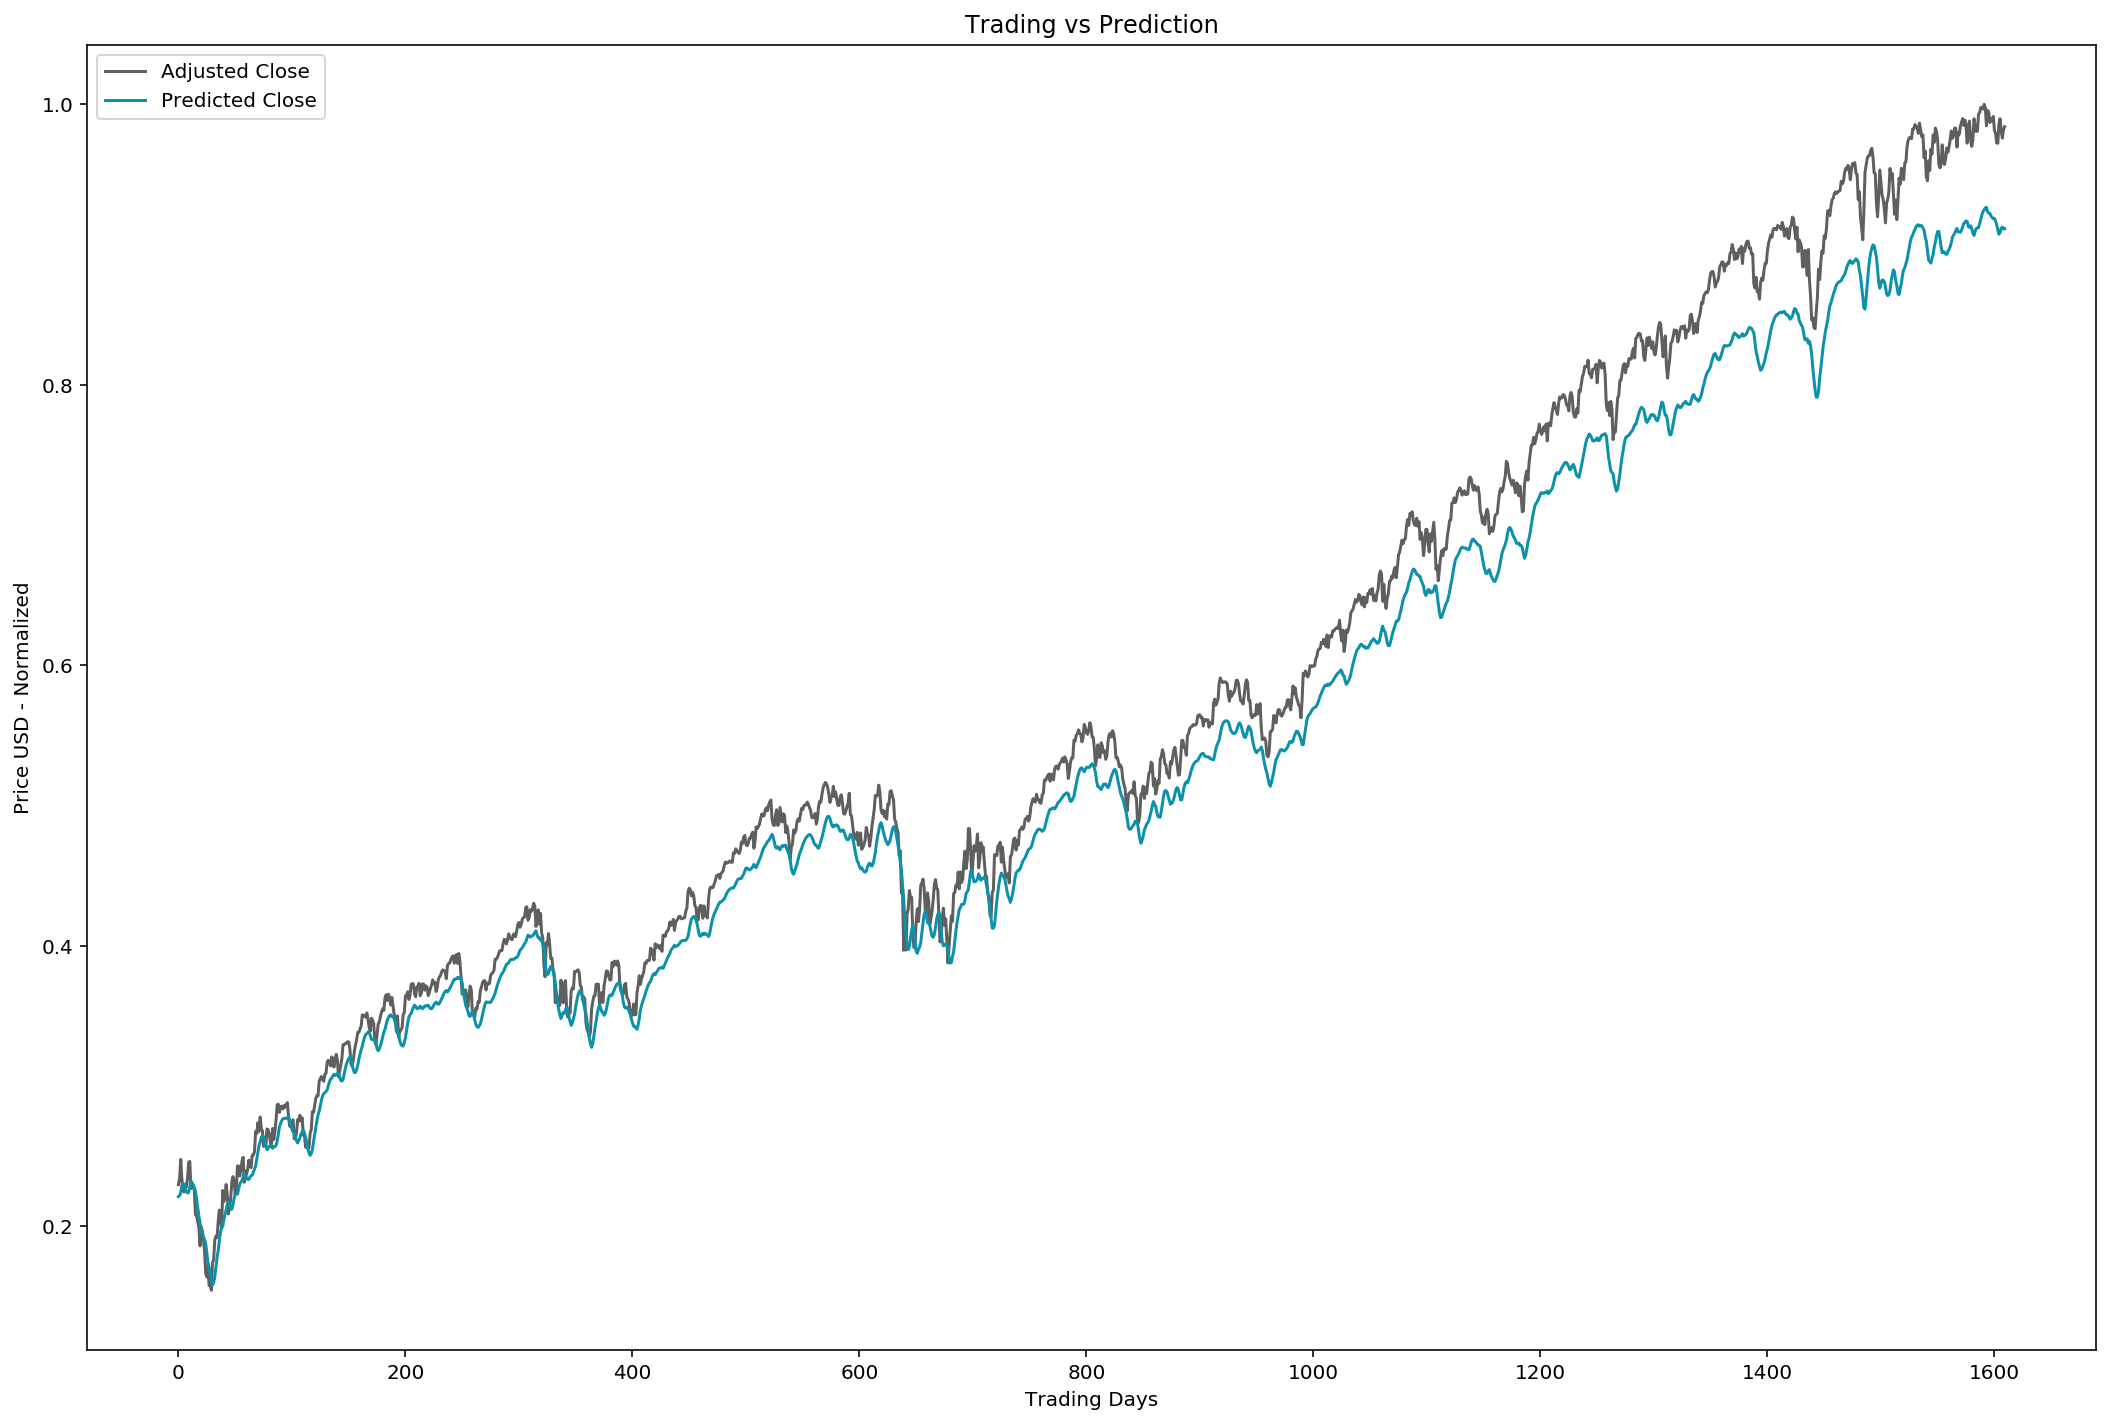

In [10]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(y_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [11]:
# The mean squared error
testScore = model.evaluate(X_close_test, y_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.001412 MSE (0.037579 RMSE)


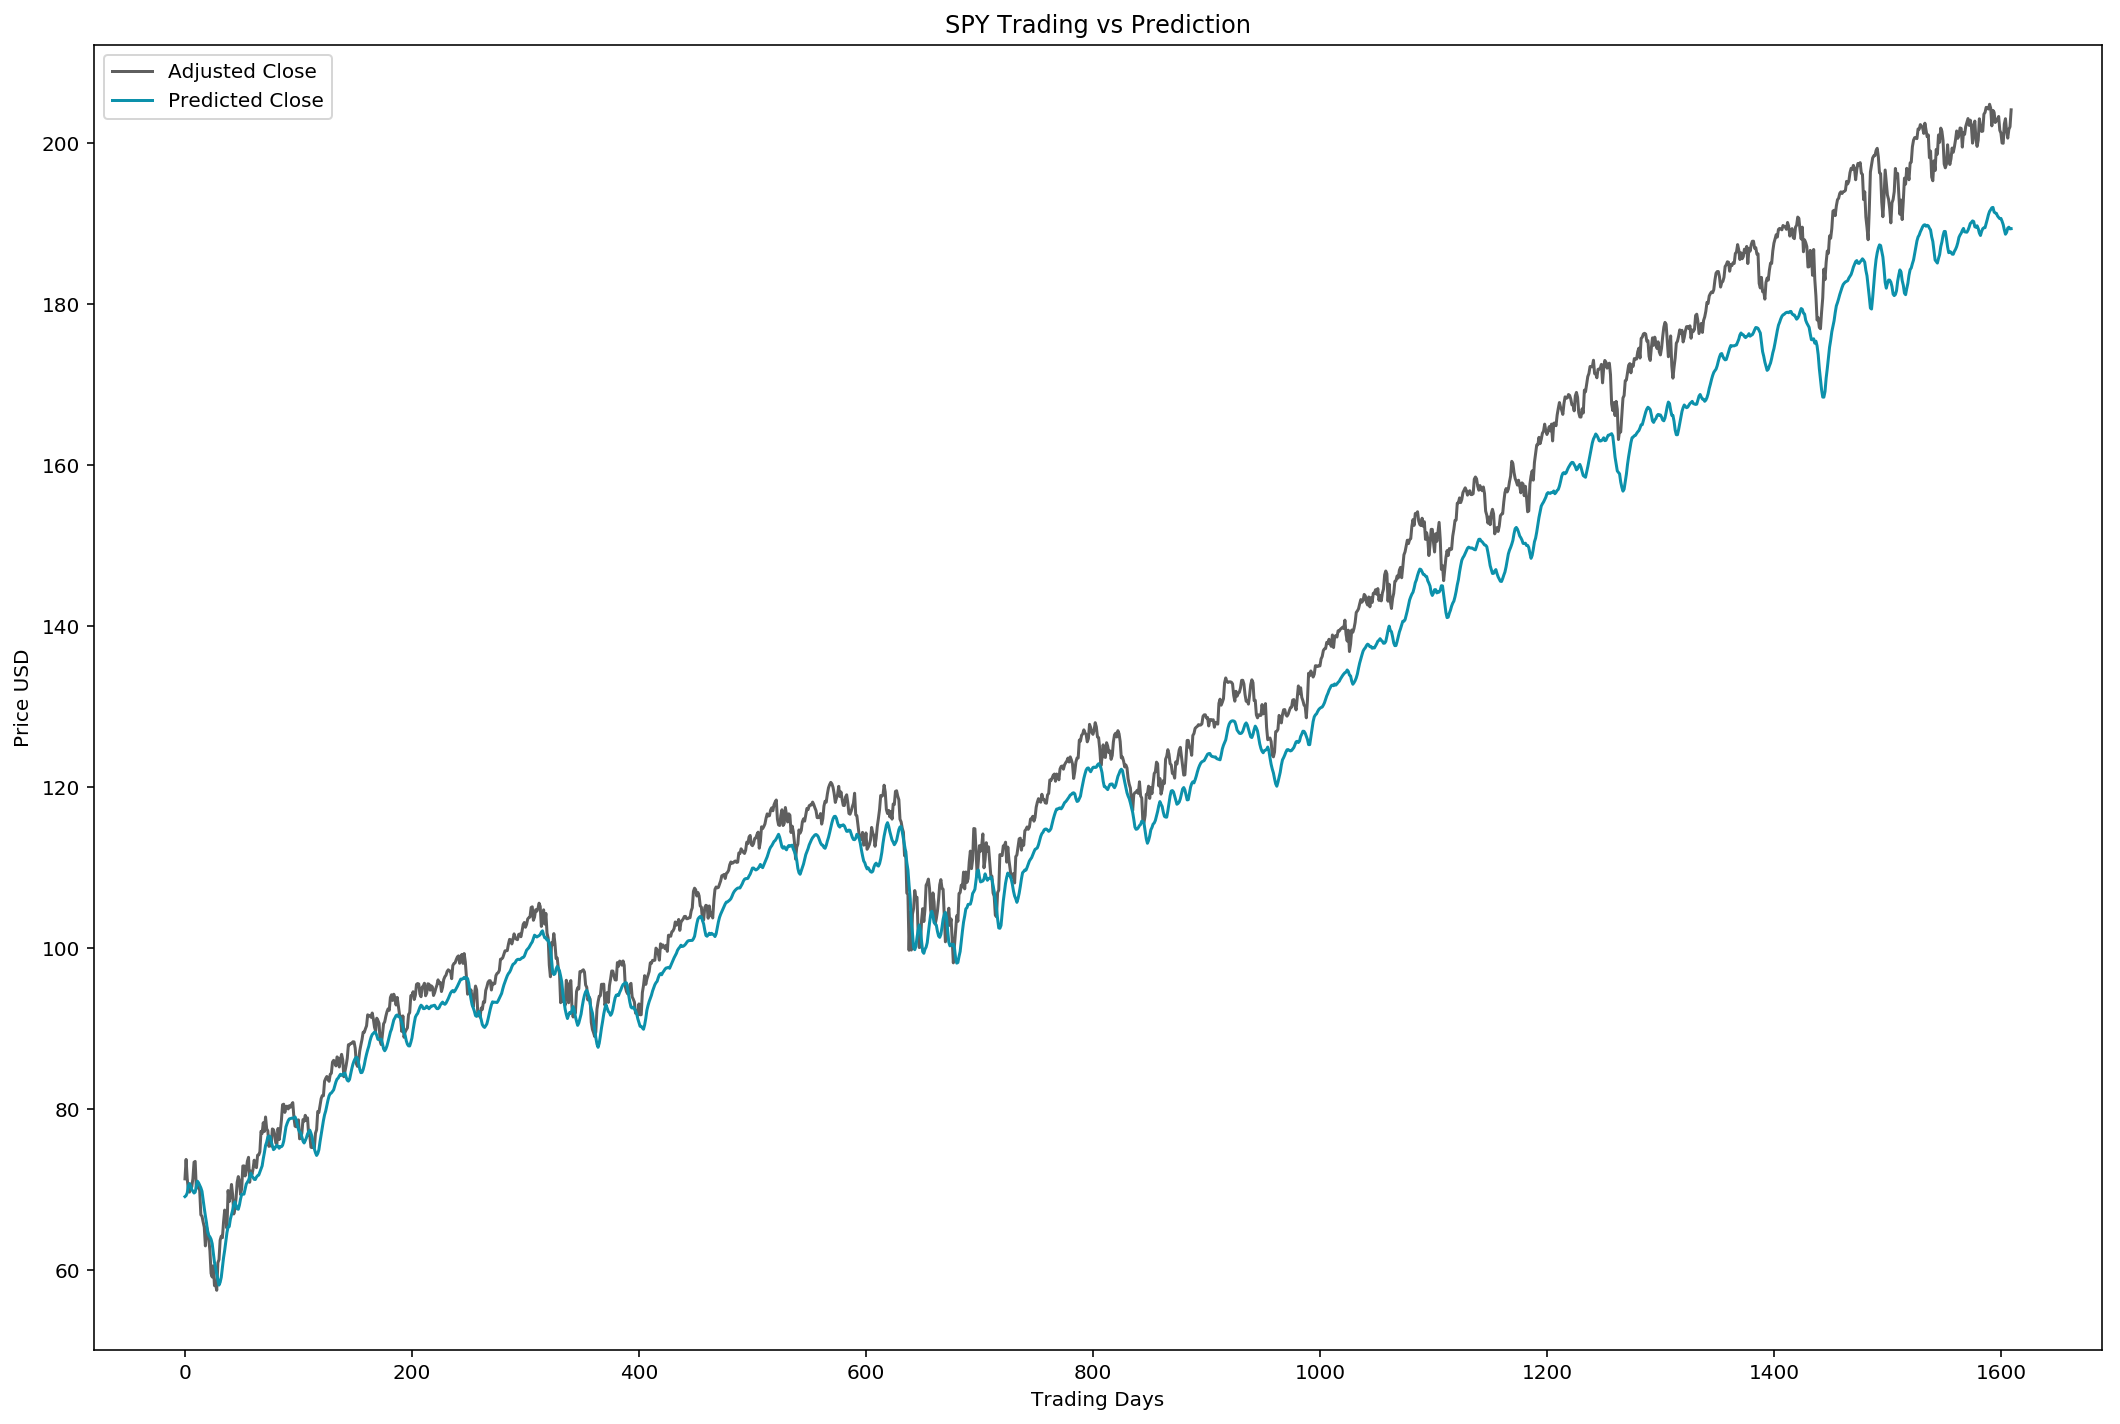

In [12]:
# Plot the predictions
close_plot = close_all[-y_close_test.shape[0]:]

pred_seq = np.array(testPredict)
#pprint(pred_seq)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)
#pprint(preds_seq_plot)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

# Log of Results:

### SPY

Lookback: 1 NumNodes: 128 Test Score: 0.000086 MSE (0.009264 RMSE)

Lookback: 3 NumNodes: 128 Test Score: 0.001619 MSE (0.040235 RMSE)

Lookback: 5 NumNodes: 128 Test Score: 0.000442 MSE (0.021017 RMSE)

Lookback: 10 NumNodes: 128 Test Score: 0.000097 MSE (0.009873 RMSE)

Lookback: 20 NumNodes: 128 Test Score: 0.000202 MSE (0.014210 RMSE)

Lookback: 40 NumNodes: 128 Test Score: 0.001412 MSE (0.037579 RMSE)


### GE
N/A

### MSFT
N/A

### AAPL
N/A